# Getting started with `flybody`
<a target="_blank" href="https://colab.research.google.com//github/elliottabe/mujoco_workshop2024/blob/main/Flybody_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
</a>
<br>
<br>

**A Colab runtime with GPU acceleration is required.** If you're using a CPU-only runtime, you can switch using the menu "Runtime > Change runtime type".


This notebook was copied and modified from [Turaga lab github](https://github.com/TuragaLab/flybody/blob/main/docs/getting-started.ipynb) and removed the dm_control dependencies. 

`flybody` is an anatomically-detailed body model of the fruit fly _Drosophila melanogaster_ for MuJoCo physics simulator and reinforcement learning (RL) applications. The fly model was developed in a collaborative effort by Google DeepMind and HHMI Janelia Research Campus. We envision our model as a platform for fruit fly biophysics simulations and for modeling neural control of sensorimotor behavior in an embodied context.

This notebook presents several python examples of our MuJoCo fly model manipulations using `mj_spec`.

For more background information, please explore:

* [MuJoCo documentation](https://mujoco.readthedocs.io/en/stable/overview.html)
* [MuJoCo](https://github.com/google-deepmind/mujoco) and tutorials therein
* [MjSpec](https://github.com/elliottabe/mujoco_workshop2025/blob/main/mjspec.ipynb)

## Installing `flybody` on Colab
### _If running notebook locally, skip this cell!_

In [ ]:

# Set up GPU rendering.
# from google.colab import files
import platform
import distutils.util
import os
import subprocess
if platform.system() != 'Darwin':
  # Configure MuJoCo to use the EGL rendering backend (requires GPU)
  print('Setting environment variable to use GPU rendering:')
  %env MUJOCO_GL=egl

  # Check if installation was succesful.
  try:
    print('Checking that the installation succeeded:')
    import mujoco
    mujoco.MjModel.from_xml_string('<mujoco/>')
  except Exception as e:
    raise e from RuntimeError(
        'Something went wrong during installation. Check the shell output above '
        'for more information.\n'
        'If using a hosted Colab runtime, make sure you enable GPU acceleration '
        'by going to the Runtime menu and selecting "Choose runtime type".')
else: 
  import mujoco
print('Installation successful.')

# Other imports and helper functions
import time
import itertools
import numpy as np

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
# clear_output()

os.environ['MUJOCO_GL'] = 'egl'
os.environ['PYOPENGL_PLATFORM'] = 'egl'
!pip install --upgrade pip
# !python -m pip install git+https://github.com/TuragaLab/flybody.git
import sys
if 'mujoco_workshop2025' not in os.getcwd():
  !git clone https://github.com/elliottabe/mujoco_workshop2024.git
  sys.path.insert(0, os.getcwd() + '/mujoco_workshop')
else: 
  sys.path.insert(0, os.getcwd())
!pip install mujoco
# Configure MuJoCo to use the EGL rendering backend (requires GPU).
# %env MUJOCO_GL=egl

Thu Jul 24 15:18:34 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.153.02             Driver Version: 570.153.02     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               On  |   00000000:41:00.0 Off |                  Off |
| 30%   37C    P8             16W /  300W |      15MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Imports

In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
import PIL.ImageDraw

import mujoco
from tqdm import tqdm
from pathlib import Path
from typing import Sequence
import mediapy as media
# from dm_control import mujoco
# from dm_control import mjcf
# from dm_control.mujoco.wrapper.mjbindings import enums
# from dm_control.mujoco.wrapper.mjbindings import mjlib
# import flybody
# from flybody.fly_envs import walk_on_ball
# from flybody.utils import display_video, any_substr_in_str

In [3]:
# Frame size and camera name-to-idx mapping for rendering.
frame_size = {'width': 640, 'height': 480}
cameras = {'track1': 0, 'track2': 1, 'track3': 2,
           'back': 3, 'side': 4, 'bottom': 5, 'hero': 6,
           'eye_right': 7, 'eye_left': 8}

In [4]:
def any_substr_in_str(substrings: Sequence[str], string: str) -> bool:
    """Checks if any of substrings is in string."""
    return any(s in string for s in substrings)

def render_frame(model, data, camera='hero', height=512, width=512, scene_option=None):
    mujoco.mj_forward(model, data)
    with mujoco.Renderer(model, height=height, width=width) as renderer:
        renderer.update_scene(data, camera=f"{camera}", scene_option=scene_option)
        pixels = renderer.render()
    return pixels

# Stand-alone fly model (outside of RL environment)

***Note:*** the flybody model was build with dm_control in mind so the way in you interact with it can be slightly different. the `phyiscs` object contains both `mjData` and `mjModel` structures like the previous notebook. In addition, the `physics` object has some helper functions that make accessing parts of the model easier.  

## Load the MuJoCo fly model
Let's load the fly model XML file `fruitfly.xml`, directly compile it to a `MjSpec` object, and print some of the model's parameters. Note that in addition to the fly itself, the # of bodies includes one additional worldbody, joints include one freejoint connecting the fly with the worldbody, and the freejoint contributes six additional degrees of freedom (3 translation, 3 rotation).

In [5]:
if 'mujoco_workshop2024' not in os.getcwd():
  flybody_path = Path.cwd() / 'mujoco_workshop2024/Models/fruitfly'
else:
  flybody_path = Path.cwd() / 'Models/fruitfly'

xml_path = flybody_path /'fruitfly.xml'

spec = mujoco.MjSpec()
spec = spec.from_file(xml_path.as_posix())
model = spec.compile()

print('# of bodies:', model.nbody)
print('# of degrees of freedom:', model.nv)
print('# of joints:', model.njnt)
print('# of actuators:', model.nu)
print("fly's mass (gr):", model.body_subtreemass[1])

# of bodies: 68
# of degrees of freedom: 108
# of joints: 103
# of actuators: 78
fly's mass (gr): 0.0009846214691323193


## Visualize the fly as loaded
As initialized, the fly is in its default resting pose where all the joint angles stored in `data.qpos` are set to zero. `data.qpos` is a view onto the underlying MuJoCo's `mjData->qpos` data structure which holds the generalized coordinates of the model. Note that the entries `qpos[:3]` correspond to the Cartesian xyz position of the root freejoint in world coordinates, and `qpos[3:7]` is the quaternion representing the root joint orientation, initially set to unit quaternion `[1, 0, 0, 0]` by default. The rest of the elements `qpos[7:]` represent joint angles of all the hinge joints of our fly model.

In [21]:
data = mujoco.MjData(model)
data.qpos

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

Visualizing several views from different cameras: "hero" and "bottom" cameras

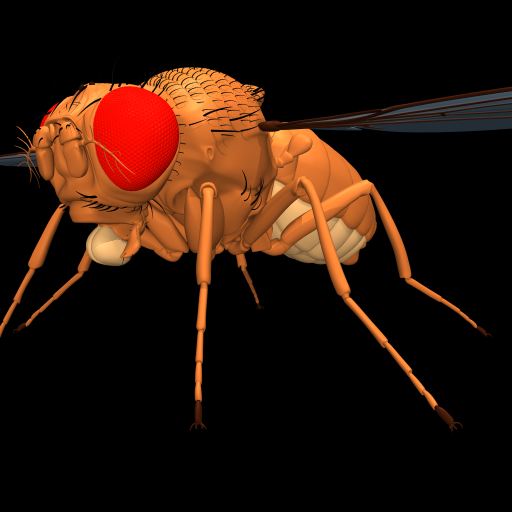

In [7]:
height, width = 512,512
camera = 'hero'
pixels = render_frame(model, data, camera=camera, height=height, width=width)
PIL.Image.fromarray(pixels)

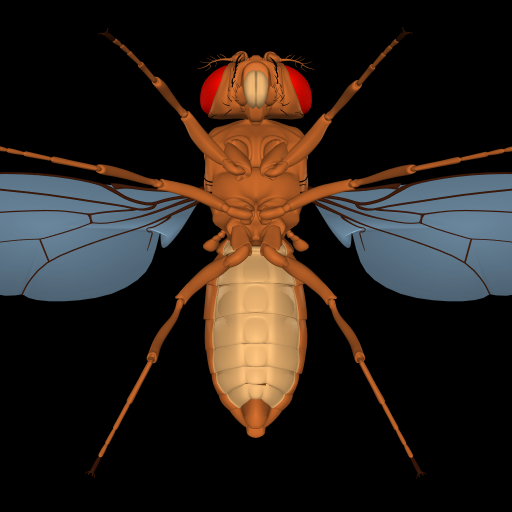

In [8]:
height, width = 512,512
camera = 'bottom'
pixels = render_frame(model, data, camera=camera, height=height, width=width)
PIL.Image.fromarray(pixels)

We can hide the external cosmetic meshes and expose the collision geom primitives, shown in blue. Also notice the adhesive geoms shown in purple and ellipsoidal wing geoms used for fluid (air) interactions during flight simulation (orange).

In [22]:
model.ngeom

160

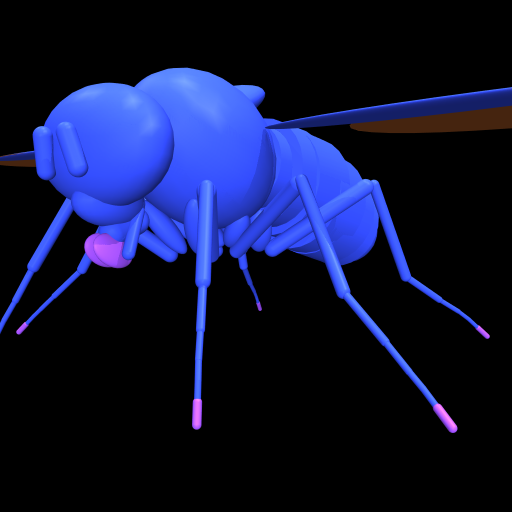

In [9]:
scene_option = mujoco.MjvOption()
scene_option.geomgroup[1] = 0  # Hide external meshes.
scene_option.geomgroup[3] = 1  # Make fluid-interactions wing ellipsoids visible (orange).
scene_option.geomgroup[4] = 1  # Make collision geoms visible (blue).
height, width = 512,512
camera = 'hero'
pixels = render_frame(model, data, camera=camera, height=height, width=width, scene_option=scene_option)
PIL.Image.fromarray(pixels)

## Load with floor and visualize
We can also load the fly model combined with a simple flat floor (and a skybox) to make more physically meaningful simulations

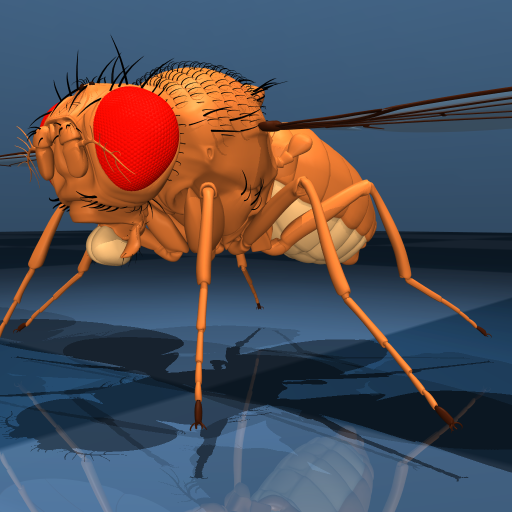

In [10]:
xml_path_floor = flybody_path/ 'floor.xml'

model = mujoco.MjModel.from_xml_path(xml_path_floor.as_posix())
data = mujoco.MjData(model)
mujoco.mj_forward(model, data)
height, width = 512,512
camera = 'hero'
pixels = render_frame(model, data, camera=camera, height=height, width=width)
PIL.Image.fromarray(pixels)

## Kinematic manipulations
Let's try out a few simple kinematic manipulations with the fly model, i.e., without computing any forces yet, we'll put the body in several poses.

For example, we can start from the default rest position in the previous image and rotate the fly around the z-axis (vertical axis, points up) by a certain angle. This will require updating the root joint quaternion stored at `qpos[3:7]`.

For the purpose of kinematic manipulations, in addition to writing into `qpos`, we will have to update other position-related entries in MuJoCo's `mjData` data structure. One way of doing this is using `physics.reset_context()` (see [dm_control paper](https://arxiv.org/abs/2006.12983) for more detail).

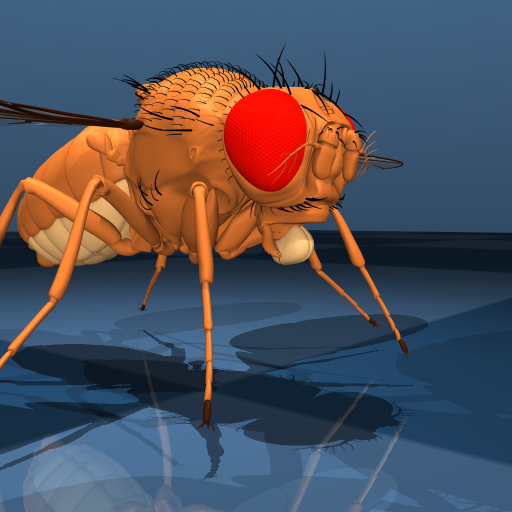

In [11]:
# Construct new root joint quaternion: 90 degree rotation around z-axis.
angle = np.pi / 2
quat = np.array([np.cos(angle/2), 0, 0, np.sin(angle/2)])
# Write into qpos and update other related quantities in mjData.
data.qpos[3:7] = quat
pixels = render_frame(model, data, camera=camera, height=height, width=width)
PIL.Image.fromarray(pixels)

Now we can try something a bit more involved.

Let's start from the default rest position again and try to fold the wings. In the model, each wing is connected to the thorax by three hinge joints (yaw, roll, pitch), effectively representing a 3-degree-of-freedom ball joint. We will need to find the wing joint angles corresponding to the folded wing position. This can be done as follows. 

In addition to the actuators, most of the fly joints have weak springs attached to them. In the adsence of actuation or external forces, these springs will act to move the joints to specific pre-defined positions, such us folded wings, retracted legs for flight, holding the proboscis retracted, etc. In each case, these joint angle are stored in the joints' `springref` attribute in the XML file, and in the corresponding `qpos_spring` attribute in MuJoCo's `mjData` data structure, exposed as `physics.model.qpos_spring` through `dm_control` here.

Let's locate the wing joints and read the folded-wing joint angles from the spring parameters:

In [12]:
wing_joints = []
wing_joints_idx = []
folded_wing_angles = []
# Loop over all model joints.
for i in range(model.njnt):
    joint_name = mujoco.mj_id2name(model,mujoco.mju_str2Type("joint"),i)
    # If wing joint, store joint name and reference angle.
    if 'wing' in joint_name:
        wing_joints_idx.append(model.jnt_qposadr[i])
        wing_joints.append(joint_name)
        folded_wing_angles.append(model.joint(joint_name).qpos_spring)

wing_joints_idx = np.array(wing_joints_idx)
folded_wing_angles = np.array(folded_wing_angles).squeeze()
wing_joints_idx,wing_joints, folded_wing_angles

(array([21, 22, 23, 24, 25, 26], dtype=int32),
 ['wing_yaw_left',
  'wing_roll_left',
  'wing_pitch_left',
  'wing_yaw_right',
  'wing_roll_right',
  'wing_pitch_right'],
 array([ 1.5,  0.7, -1. ,  1.5,  0.7, -1. ]))

Now we can write these wing angles into their corresponding fields in `qpos`. Note that we are now using named (and vectorized) indexing to write the wing angles to `qpos`.

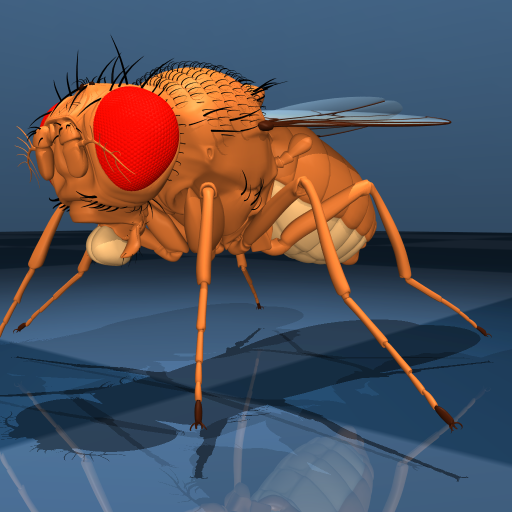

In [13]:
mujoco.mj_resetData(model, data)
data.qpos[wing_joints_idx] = folded_wing_angles
mujoco.mj_forward(model, data)
pixels = render_frame(model, data, camera=camera, height=height, width=width)
PIL.Image.fromarray(pixels)

In the same way, we can (kinematically) put the legs into the retracted flight position, which is stored in `physics.model.qpos_spring`, as before:

/tmp/ipykernel_1153152/3437608447.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data.qpos[idx] = model.joint(name).qpos_spring


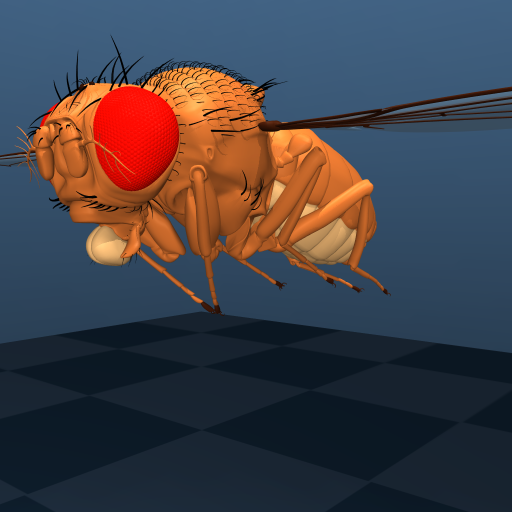

In [14]:
mujoco.mj_resetData(model, data)
# Loop over all joints.
for i in range(model.njnt):
    name = mujoco.mj_id2name(model,mujoco.mju_str2Type("joint"),i)
    idx = model.jnt_qposadr[i]
    # If leg joint, set the joint angle to be equal to its corresponding
    # reference spring angle.
    if any_substr_in_str(['coxa', 'femur', 'tibia', 'tarsus'], name) & (model.joint(name).qpos_spring is not None):
        data.qpos[idx] = model.joint(name).qpos_spring
# Also, lift the fly by setting the z-coordinate of fly's root joint.
data.qpos[2] = 1.  # Here, units: cm.

pixels = render_frame(model, data, camera=camera, height=height, width=width)
PIL.Image.fromarray(pixels)

## Kinematic replay: fold wings
Sequences of kinematically-set poses can be used for kinematic replay animations.

In this example, we will gradually move the wings from their default position to the folded position we obtained before. At each step we will render a frame and in the end generate a video from the sequence of frames:

In [15]:
n_steps = 150
frames = []
for i in tqdm(range(n_steps)):
    wing_angles = np.array(folded_wing_angles) * np.sin(np.pi/2 * i/n_steps)
    data.qpos[wing_joints_idx] = wing_angles
    pixels = render_frame(model, data, camera=camera, height=height, width=width)
    frames.append(pixels)

media.show_video(frames)

100%|██████████| 150/150 [00:18<00:00,  8.21it/s]


## Simulating physics: procedurally actuated body movements

Now we can try to run actual physical simulations.

In this example, we will procedurally control the fly's actuators and step the simulation in time to generate a sequence of movements. First, let's prepare groups of actuator names to control at each phase of the simulation. By convention, all the joint actuators in our model (in contrast to tendon actuators) have the same name as the joint they actuate.

In [16]:
def get_leg_actuator(leg, return_idxs=False):
    if return_idxs:
        return [model.actuator(name).id for name in
                [f'{joint}_{leg}' for joint in ['coxa', 'femur', 'tibia', 'tarsus', 'tarsus2']]]
    else:
        return [f'{joint}_{leg}' for joint in ['coxa', 'femur', 'tibia', 'tarsus', 'tarsus2']]

# Names of leg actuators.
leg_actuators_L1 = get_leg_actuator('T1_left', return_idxs=True)
leg_actuators_R1 = get_leg_actuator('T1_right', return_idxs=True)
leg_actuators_L2 = get_leg_actuator('T2_left', return_idxs=True)

# Amplitudes of joint motion for front and middle legs.
amplitude_front = 0.5 * np.array([1, -1, 2, 1, 1])
amplitude_mid = 0.5 * np.array([0.5, -0.5, -2, 1, 2])

Now we can simulate the motion sequence. At each control step, we will be writing the control into MuJoCo's `mjData->ctrl`, exposed here as `data.ctrl`. We will also engage the leg adhesion actuators at a certain point during the motion sequence. 

The control semantics is the target joint angles for position actuators, and (scaled) force for force and adhesion actuators (see [MuJoCo docs](https://mujoco.readthedocs.io/en/stable/overview.html) for more details). With the exception of wings and adhesion, our model uses position actuators. The wings are powered by force (torque) actuators.

We will change the control once every `physics_to_ctrl_ratio == 10` simulation steps, to ensure simulation stability (see `dm_control` [paper](https://arxiv.org/abs/2006.12983) for more details).

Note that in the first part of the motion sequence, "Let wings fold", we don't alter `data.ctrl` yet and it is still zero after resetting the simulation with `mj_resetData()`. Nevertheless, the wings will fold -- this is achieved by the weak springs acting to move the wings to a reference position, as described above.

In [17]:
n_steps = 100
physics_to_ctrl_ratio = 10
frames = []

# Reset physics to initial default state.
mujoco.mj_resetData(model, data)

# Let wings fold.
for i in range(n_steps):
    pixels = render_frame(model, data, camera='hero', height=height, width=width)
    frames.append(pixels)
    for _ in range(physics_to_ctrl_ratio):
        mujoco.mj_step(model, data)

# Twist head.
for i in range(n_steps):
    pixels = render_frame(model, data, camera=camera, height=height, width=width)
    frames.append(pixels)
    data.actuator('head_twist').ctrl = 1.5 * np.sin(2*np.pi * i/n_steps)
    for _ in range(physics_to_ctrl_ratio):
        mujoco.mj_step(model, data)

# Move middle right leg.
for i in range(n_steps+50):
    if i <= n_steps:
        data.ctrl[leg_actuators_L2] = amplitude_mid * np.sin(np.pi * i/n_steps)
    for _ in range(physics_to_ctrl_ratio):
        mujoco.mj_step(model, data)
    pixels = render_frame(model, data, camera='hero', height=height, width=width)
    frames.append(pixels)

# Activate middle leg adhision to prevent slipping when front legs are lifted later.
data.actuator('adhere_claw_T2_right').ctrl = 1.
data.actuator('adhere_claw_T2_left').ctrl = 1.

# Lift fronts legs with lag.
for i in range(n_steps+100):
    left_angle = np.pi * i/n_steps
    right_angle = np.pi * i/n_steps - np.pi/5
    if left_angle <= np.pi:
        data.ctrl[leg_actuators_L1] = amplitude_front * np.sin(left_angle)
    if 0 < right_angle <= np.pi:
       data.ctrl[leg_actuators_R1] = amplitude_front * np.sin(right_angle)
    for _ in range(physics_to_ctrl_ratio):
        mujoco.mj_step(model, data)
    pixels = render_frame(model, data, camera='hero', height=height, width=width)
    frames.append(pixels)

media.show_video(frames)

## Actuate entire body with random actions
Now let's actuate all of the degrees of freedom at once with random control.

As force actuators (wings) and position actuators (the rest of the body) have different control semantics (scaled force and target joint angles, respectively), we'll actuate them with control signals of different magnitude. Let's find the indices for each actuator group first:

In [18]:
wing_act_indices = []  # Force actuators.
body_act_indices = []  # Position actuators.
# Loop over all actuators.
for i in range(model.nu):
    name = mujoco.mj_id2name(model, mujoco.mju_str2Type("actuator"),i)
    # Store wing actuator indices and rest of indices separately.
    if 'wing' in name:
        wing_act_indices.append(i)
    else:
        body_act_indices.append(i)

print(wing_act_indices)
print(body_act_indices)

[14, 15, 16, 17, 18, 19]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77]


Run simulation and actuate the fly body with random actions.

In [19]:
n_body_actions = len(body_act_indices)
n_wing_actions = len(wing_act_indices)

n_steps = 300
physics_to_ctrl_ratio = 10
frames = []

# Reset simulatiomn to initial default state.
mujoco.mj_resetData(model, data)

for i in range(n_steps):
    pixels = render_frame(model, data, camera='hero', height=height, width=width)
    frames.append(pixels)
    data.ctrl[body_act_indices] = np.random.uniform(-.3, .3, n_body_actions)
    data.ctrl[wing_act_indices] = np.random.uniform(-.005, .005, n_wing_actions)
    for _ in range(physics_to_ctrl_ratio):
        mujoco.mj_step(model, data)

media.show_video(frames)